**Random Forest**

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import the CAD=X currency pair data from the CSV file
df = pd.read_csv('cad_x_currency_data.csv', index_col=0)
df

,Ticker,Open,High,Low,Close,Adj Close,Time
Date,,,,,,,
2008-08-01,CAD=X,1.02340,1.02940,1.02290,1.02460,1.02460,2
2008-08-04,CAD=X,1.02800,1.03680,1.02620,1.03640,1.03640,8
2008-08-05,CAD=X,1.03630,1.04480,1.03630,1.04260,1.04260,14
2008-08-06,CAD=X,1.04260,1.04930,1.04000,1.04750,1.04750,20
2008-08-07,CAD=X,1.04760,1.05330,1.04490,1.05200,1.05200,26
...,...,...,...,...,...,...,...
2023-07-24,CAD=X,1.32240,1.32276,1.31542,1.32240,1.32240,38937
2023-07-25,CAD=X,1.31746,1.32095,1.31466,1.31746,1.31746,38947
2023-07-26,CAD=X,1.31871,1.32352,1.31720,1.31871,1.31871,38957


In [4]:
df.shape

(3905, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3905 entries, 2008-08-01 to 2023-07-28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     3905 non-null   object 
 1   Open       3905 non-null   float64
 2   High       3905 non-null   float64
 3   Low        3905 non-null   float64
 4   Close      3905 non-null   float64
 5   Adj Close  3905 non-null   float64
 6   Time       3905 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 244.1+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Time
count,3905.000000,3905.000000,3905.000000,3905.000000,3905.000000,3905.000000
mean,1.198423,1.202731,1.194271,1.198412,1.198412,19457.018438
std,0.136652,0.136947,0.136378,0.136623,0.136623,11274.606568
min,0.943000,0.947200,0.940600,0.943200,0.943200,2.000000
25%,1.049800,1.054770,1.044800,1.049800,1.049800,9693.000000
50%,1.254420,1.259230,1.250170,1.254400,1.254400,19458.000000
75%,1.315860,1.319310,1.312870,1.315800,1.315800,29218.000000
max,1.458030,1.468730,1.449370,1.457800,1.457800,38977.000000


In [7]:
# Check for missing values in each column
missing_values = df.isna().sum()
print(missing_values)

Ticker       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Time         0
dtype: int64


**Feature Engineering**

In [8]:
# Calculate moving averages
df['MA10'] = df['Close'].rolling(window=10).mean() #10-day moving average
df['MA50'] = df['Close'].rolling(window=50).mean() #50-day moving average

In [12]:
# Since moving averages introduce NaN values for the initial rows, we need to handle these rows
# Backfill null values
df = df.fillna(method='bfill')
# df_clean = df.dropna()

In [10]:
# Display the first few rows of the dataframe with new features
df.head()

,Ticker,Open,High,Low,Close,Adj Close,Time,MA10,MA50
Date,,,,,,,,,
2008-08-01,CAD=X,1.0234,1.0294,1.0229,1.0246,1.0246,2,1.05333,1.06213
2008-08-04,CAD=X,1.0280,1.0368,1.0262,1.0364,1.0364,8,1.05333,1.06213
2008-08-05,CAD=X,1.0363,1.0448,1.0363,1.0426,1.0426,14,1.05333,1.06213
2008-08-06,CAD=X,1.0426,1.0493,1.0400,1.0475,1.0475,20,1.05333,1.06213
2008-08-07,CAD=X,1.0476,1.0533,1.0449,1.0520,1.0520,26,1.05333,1.06213


In [11]:
df.shape

(3905, 9)

In [13]:
# List of features to include moving averages and any other predictors you've identified
features_columns = ['Open', 'High', 'Low', 'Adj Close', 'MA10', 'MA50']

# Features
X = df[features_columns]

# Target variable
y = df['Close']


**Train-test split chronological**

In [14]:
# Calculate the index for the split
split_idx = int(len(df) * 0.8)

In [15]:
# Split the features
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]

In [16]:
# Split the target
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3124, 6), (781, 6), (3124,), (781,))

**Hyperparameter Optimization**

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the model
rf = RandomForestRegressor()

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Best estimator (model)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


**Model Evaluation**

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions
predictions = best_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

print(f"RMSE: {rmse}, MAE: {mae}")


RMSE: 0.00015867762021979132, MAE: 9.706882142226381e-05


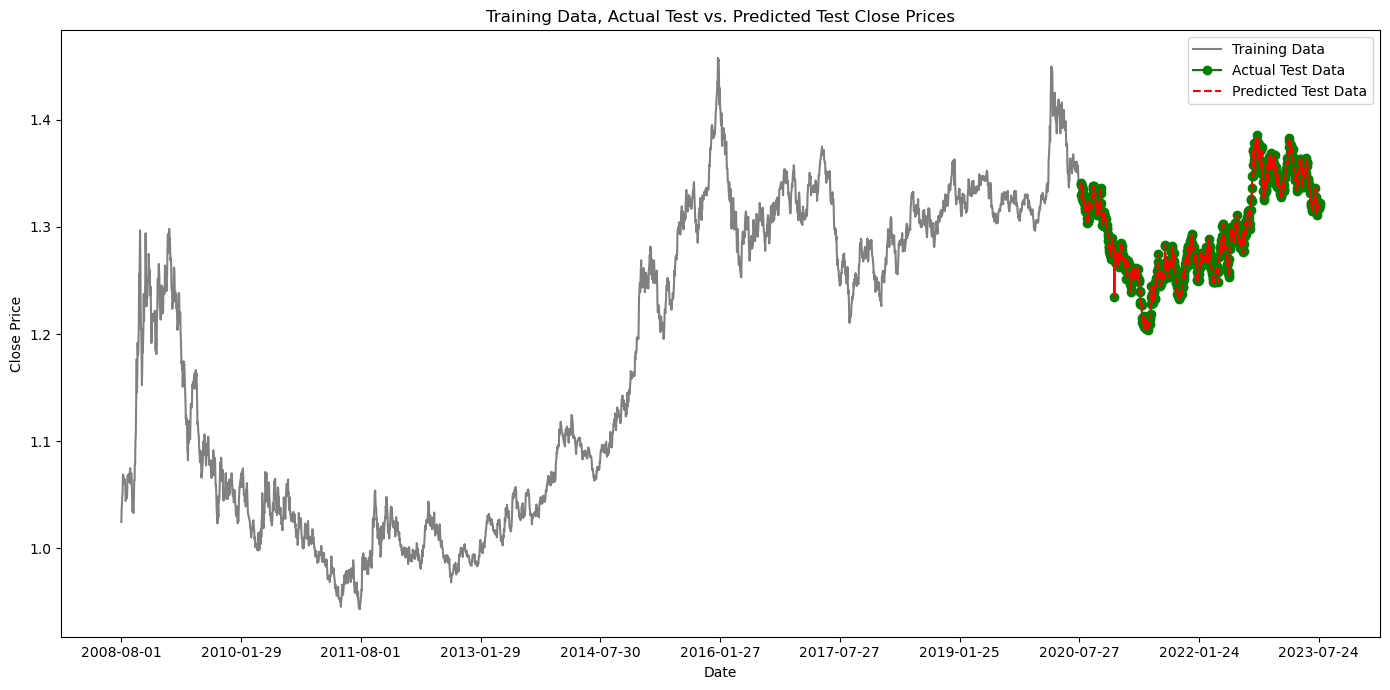

In [31]:
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(df.index[:split_idx], y_train, label='Training Data', color='gray')

# Plot testing data
plt.plot(df.index[split_idx:split_idx+len(y_test)], y_test, label='Actual Test Data', color='green', marker='o')

# Plot predictions on the test set
plt.plot(df.index[split_idx:split_idx+len(y_test)], predictions, label='Predicted Test Data', color='red', linestyle='--')

plt.title('Training Data, Actual Test vs. Predicted Test Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Display fewer x-ticks
tick_spacing = int(len(df.index) / 10)  # display a tick every 10% of the dataset length
plt.xticks(df.index[::tick_spacing])

plt.tight_layout()
plt.show()


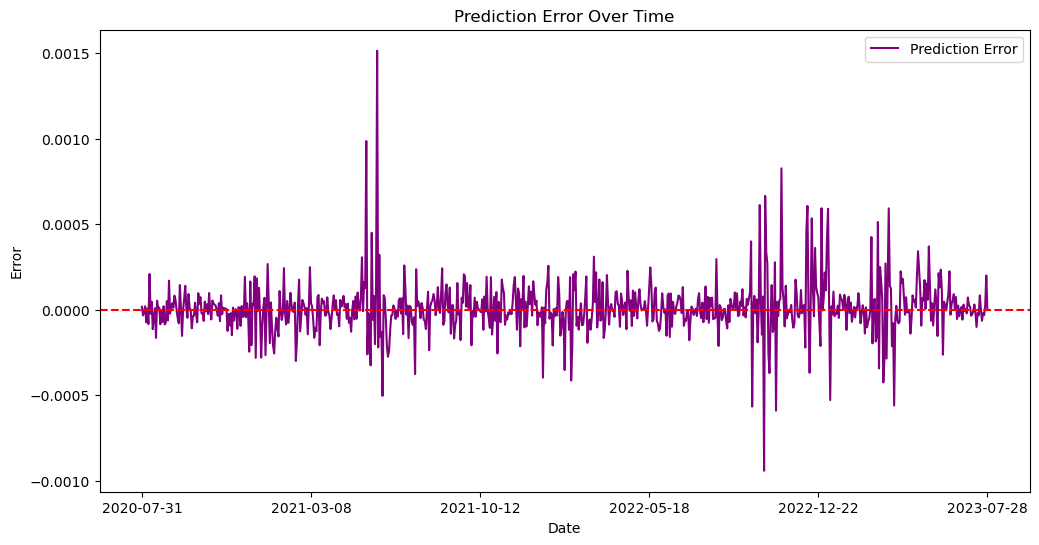

In [33]:
# Calculate errors
errors = y_test - predictions

plt.figure(figsize=(12, 6))

# Plot errors over time
plt.plot(df.index[split_idx:split_idx+len(y_test)], errors, label='Prediction Error', color='purple')
plt.axhline(y=0, color='r', linestyle='--')  # Optional: baseline at 0

# Reduce the number of x-ticks
tick_spacing = int(len(y_test) / 5)  # For example, show a tick every 20% of the length of y_test
plt.xticks(df.index[split_idx:split_idx+len(y_test)][::tick_spacing])

plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Prediction Error Over Time')
plt.legend()
plt.show()
